In [1]:
import os

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython.display import Image as IPImage
from PIL import Image

from tqdm import tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [39]:
# Зачем это? Нормализация данных ускоряет сходимость
transform = T.Compose([T.ToTensor(), T.Normalize((0.5,), (0.5,))])
train = torchvision.datasets.MNIST('.', train=True, transform=transform, download=True)
loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)

In [40]:
# Простая сеть-энкодер
class Encoder(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
    def forward(self, x):
        return self.net(x)

In [41]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Tanh(),
            nn.Unflatten(1, (1, 28, 28))
        )
    def forward(self, z):
        return self.net(z)

In [42]:
# Модель
latent_dim = 64
encoder = Encoder(latent_dim)
decoder = Decoder(latent_dim)
# Оптимизатор и loss
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)
criterion = nn.MSELoss()


In [43]:
# Конвертирую загрузчик данных в итератор для более удобного отображения
data_iter = iter(loader)

try:
    x_fixed, _ = next(data_iter)

except StopIteration:
    data_iter = iter(loader)
    x_fixed, _ = next(data_iter)

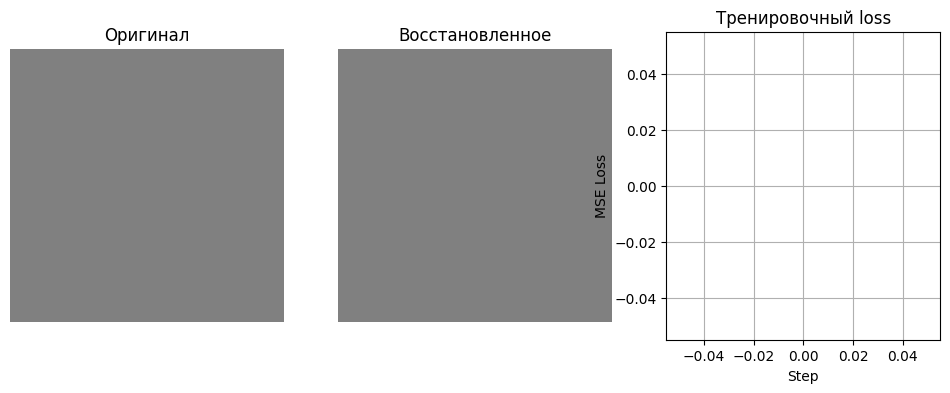

In [44]:
# Настраиваю график визуализации
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,4))

# Инициализирую пустые изображения чтобы потом их обновлять в 
# процессе обучения декодера
# Используем vmin=-1, vmax=1 потому что данные нормализованы
im1 = ax1.imshow(np.zeros((28,28)), cmap='gray', vmin=-1, vmax=1)
ax1.set_title('Оригинал')
ax1.axis('off')

im2 = ax2.imshow(np.zeros((28,28)), cmap='gray', vmin=-1, vmax=1)
ax2.set_title('Восстановленное')
ax2.axis('off')

# Третий график будет показывать лосс
ax3.set_title('Тренировочный loss')
ax3.set_xlabel('Step')
ax3.set_ylabel('MSE Loss')
line, = ax3.plot([], [], 'b-')
ax3.grid(True)

# Списки для сохранения данных
losses = []
steps = []

In [45]:
def animate(frame):
    ''' 
    Это функция для анимирования результатов обучения
    '''

    global data_iter, losses, steps

    # Получаем батч с данным (цикл по датасету)
    try:
        x, _ = next(data_iter)

    except StopIteration:
        # Ecли прошли весь датасет, рестарт
        data_iter = iter(loader)
        x, _ = next(data_iter)

    # Тренировочный шаг
    z = encoder(x)
    x_rec = decoder(z)
    loss = criterion(x_rec, x)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Обновляем списки
    losses.append(loss.item())
    steps.append(frame)

    # Обновляем изображение
    x_orig = x[0].detach().cpu().numpy().squeeze()
    x_rec_img = x_rec[0].detach().cpu().numpy().squeeze()

    im1.set_array(x_orig)
    im2.set_array(x_rec_img)

    line.set_data(steps, losses)

    if len(losses) > 0:
        ax3.set_xlim(0, max(steps) + 1)
        ax3.set_ylim(0, max(losses) * 1.1)

    fig.suptitle(f'Autoencoder Training - Step: {frame}, Loss: {loss.item():.4f}')
    
    return [im1, im2, line]

In [46]:
%%time
# Создаем анимацию:
# interval: ms между фреймами
# frames: кол-во шагов которые надо визуализировать
# repeat: зациклить ли анимацию
anim = animation.FuncAnimation(
    fig,
    animate,
    frames=300,
    interval=40,
    blit=True,
    repeat=False
)

CPU times: total: 188 ms
Wall time: 78 ms


In [47]:
%%time
anim.save('autoencoder_training.gif', writer='pillow', fps=20)

CPU times: total: 2min 2s
Wall time: 42.2 s


Визуализация процесса обучения:

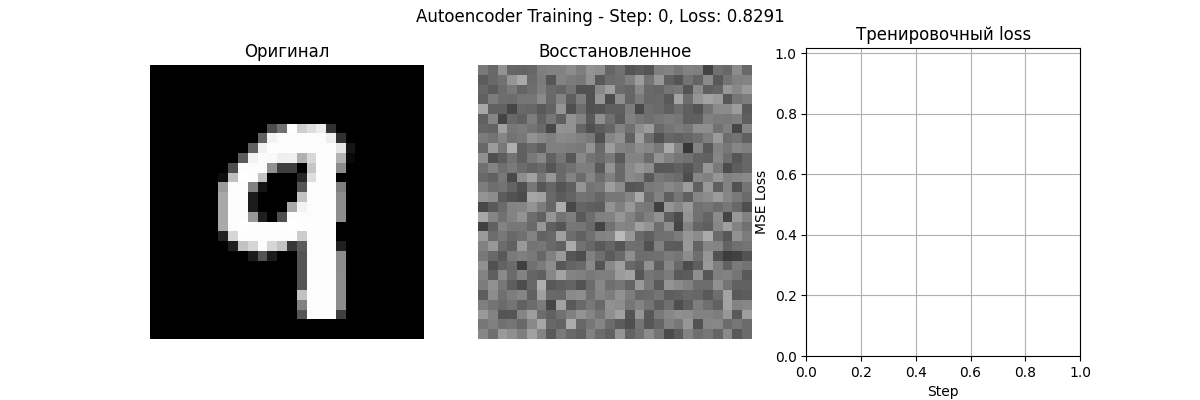

In [48]:
display(IPImage(data=open('autoencoder_training.gif','rb').read(), format='png'))

Сохраняем полученную модель

In [49]:
os.makedirs('model', exist_ok = True)

torch.save(encoder.state_dict(), 'model/encoder.pth')
torch.save(decoder.state_dict(), 'model/decoder.pth')

In [50]:
encoder.load_state_dict(torch.load('model/encoder.pth'))
decoder.load_state_dict(torch.load('model/decoder.pth'))
encoder.eval()
decoder.eval()


Decoder(
  (net): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Tanh()
    (4): Unflatten(dim=1, unflattened_size=(1, 28, 28))
  )
)

Попробую применить обученую модель на своей фотографии

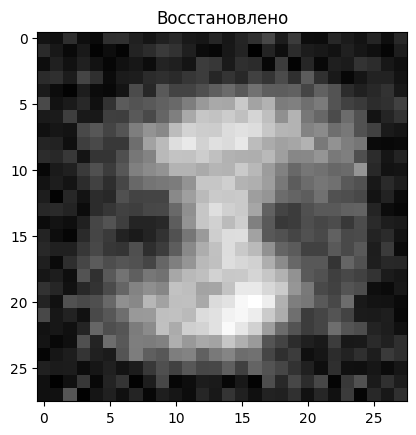

In [51]:
# Препроцессинг фото
transform = T.Compose([
    T.Grayscale(),
    T.Resize((28,28)),
    T.ToTensor()
])

img = Image.open('5.png')
x = transform(img).unsqueeze(0)

with torch.no_grad():
    encoded = encoder(x)
    rec = decoder(encoded)

# Визуализация результата
plt.imshow(rec.squeeze().numpy(), cmap='gray')
plt.title("Восстановлено")
plt.show()

Начинаем про диффузию

In [52]:
# Берем 1 изображение из датасета (первый батч)
x0, _ = next(iter(loader))
x0 = x0[0:1].to(device)

# Кол-во шагов диффузии
num_steps = 10
t = 1000
timesteps = torch.linspace(0, t-1, num_steps, dtype=torch.long).to(device)

In [3]:
# Количество шагов диффузии
T = 1000

# Линейный график изменения беты от 1e-4 до 0.02
beta_start = 1e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T)

# α_t = 1 - β_t
alphas = 1. - betas

# Кумулятивное произведение ᾱ_t = ∏_{s=1}^{t} α_s
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = torch.cat([torch.tensor([1.0]), alphas_cumprod[:-1]])

# Для удобства:
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
sqrt_recip_alphas = torch.sqrt(1. / alphas)
sqrt_recipm1_alphas = torch.sqrt(1. / alphas - 1)

In [4]:
# Функция q(x_t | x_0)
@torch.no_grad()
def q_sample(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    sqrt_alpha_bar = torch.sqrt(alphas_cumprod[t])[:, None, None, None]
    sqrt_one_minus = torch.sqrt(1 - alphas_cumprod[t])[:, None, None, None]
    return sqrt_alpha_bar * x0 + sqrt_one_minus * noise

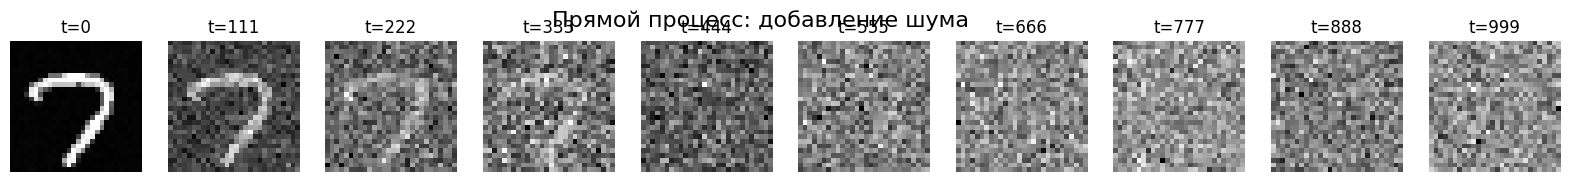

In [ ]:
# Генерация и визуализация
fig, axs = plt.subplots(1, num_steps, figsize=(20, 2))
for i, t in enumerate(timesteps):
    t_int = t.item()
    xt = q_sample(x0, torch.tensor([t_int], device=device))
    img = xt[0].detach().cpu().squeeze()
    axs[i].imshow(img, cmap="gray")
    axs[i].set_title(f"t={t_int}")
    axs[i].axis("off")
plt.suptitle("Прямой процесс: добавление шума", fontsize=16)
plt.show()

Модель

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# --- Вспомогательная time embedding ---
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


# --- Простая U-Net-подобная модель ---
class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.Linear(1, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
        )

        self.t_emb_proj = nn.Linear(128, 64)  # приведение к 64 каналам

        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv5 = nn.Conv2d(32, 1, 3, padding=1)

        self.act = nn.ReLU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x, t):
        t = t[:, None].float() / T  # нормализуем t к [0, 1]
        t_emb = self.time_mlp(t)  # [B, 128]
        t_emb = self.t_emb_proj(t_emb)  # [B, 64]
        t_emb = t_emb[:, :, None, None]  # [B, 64, 1, 1]

        x = self.act(self.conv1(x))  # [B, 32, 28, 28]
        x = self.act(self.conv2(x) + t_emb)  # [B, 64, 28, 28]
        x = self.act(self.conv3(x))
        x = self.act(self.conv4(x))
        x = self.conv5(x)  # [B, 1, 28, 28]
        return x


Функция потерь

In [6]:
def get_loss(model, x0, t, noise):
    """
    model: модель, которая предсказывает шум ε_θ(x_t, t)
    x0: исходное изображение
    t: таймстемп (Batch of ints)
    noise: шум, который мы добавили вручную

    Возвращает: MSE loss между предсказанным и реальным шумом
    """
    # Получаем параметры шума для каждого t
    sqrt_alpha_bar_t = sqrt_alphas_cumprod[t].view(-1, 1, 1, 1).to(x0.device)
    sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1).to(x0.device)

    # Создаем зашумленное изображение x_t
    xt = sqrt_alpha_bar_t * x0 + sqrt_one_minus_alpha_bar_t * noise

    # Прогоняем через модель, чтобы получить предсказание шума
    pred_noise = model(xt, t)

    # Вычисляем MSE между предсказанным и истинным шумом
    return F.mse_loss(pred_noise, noise)


Тренировка

In [7]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# --- Готовим данные ---
transform = transforms.Compose([
    transforms.ToTensor(),  # [0,1]
    lambda x: x * 2 - 1     # [-1,1]  как в диффузиях принято
])

dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# --- Модель и оптимизатор ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)




In [ ]:
torch.save(model.state_dict(), "diffusion_model.pth")

In [ ]:
# # Берем 1 изображение из датасета (первый батч)
# x0, _ = next(iter(loader))
# x0 = x0[0:1].to(device)

# # Кол-во шагов диффузии
# num_steps = 10
# t = 1000
# timesteps = torch.linspace(0, t-1, num_steps, dtype=torch.long).to(device)

In [8]:
def get_beta_schedule(T, beta_start=1e-4, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, T)


In [ ]:
@torch.no_grad()
def sample_ddpm(model, n_samples, img_size, T, device):
    model.eval()
    x = torch.randn(n_samples, 1, img_size, img_size).to(device)  # начнем с гауссовского шума

    for t in reversed(range(1, T)):
        t_tensor = torch.full((n_samples,), t, device=device, dtype=torch.long)
        noise_pred = model(x, t_tensor)  # предсказание шума ε_θ(x_t, t)

        beta_t = get_beta_schedule(T)[t]
        alpha_t = 1.0 - beta_t
        alpha_bar_t = torch.prod(1.0 - get_beta_schedule(T)[:t + 1])

        # mean of q(x_{t-1} | x_t, x_0)
        mean = (1 / torch.sqrt(alpha_t)) * (x - (beta_t / torch.sqrt(1 - alpha_bar_t)) * noise_pred)

        if t > 1:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)

        x = mean + torch.sqrt(beta_t) * noise

    return x


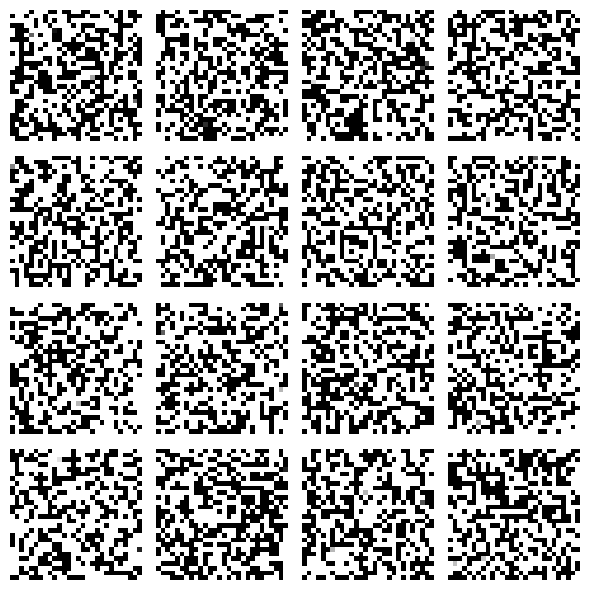

In [10]:
samples = sample_ddpm(model, n_samples=16, img_size=28, T=T, device=device)

# Визуализация
samples = samples.cpu().clamp(-1, 1) * 0.5 + 0.5  # [-1, 1] -> [0, 1]

fig, axs = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(samples[i, 0], cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()


In [11]:
# --- Тренируем ---

n_epochs = 2
T = 1000  # шагов зашумления

for epoch in range(n_epochs):
    pbar = tqdm(dataloader)
    for x0, _ in pbar:
        x0 = x0.to(device)
        t = torch.randint(0, T, (x0.size(0),), device=device).long()
        noise = torch.randn_like(x0)

        loss = get_loss(model, x0, t, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_description(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")

Epoch 1 | Loss: 0.5118:   2%|▏         | 8/469 [00:02<02:25,  3.17it/s]


KeyboardInterrupt: 

In [62]:
torch.save(model.state_dict(), "diffusion_model50.pth")

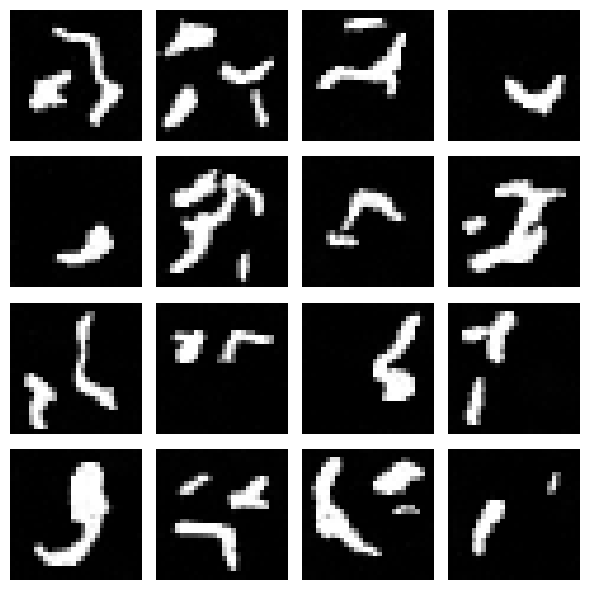

In [63]:
samples = sample_ddpm(model, n_samples=16, img_size=28, T=T, device=device)

# Визуализация
samples = samples.cpu().clamp(-1, 1) * 0.5 + 0.5  # [-1, 1] -> [0, 1]

fig, axs = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(samples[i, 0], cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [65]:
model = SimpleUNet()
model.load_state_dict(torch.load("diffusion_model50.pth"))
model.eval()  # обязательно для отключения dropout, batchnorm и т.п.


SimpleUNet(
  (time_mlp): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (t_emb_proj): Linear(in_features=128, out_features=64, bias=True)
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [66]:
# --- Тренируем ---

n_epochs = 50
T = 1000  # шагов зашумления

for epoch in range(n_epochs):
    pbar = tqdm(dataloader)
    for x0, _ in pbar:
        x0 = x0.to(device)
        t = torch.randint(0, T, (x0.size(0),), device=device).long()
        noise = torch.randn_like(x0)

        loss = get_loss(model, x0, t, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_description(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")

Epoch 1 | Loss: 0.0266: 100%|██████████| 469/469 [02:20<00:00,  3.33it/s]
Epoch 2 | Loss: 0.0249: 100%|██████████| 469/469 [02:23<00:00,  3.27it/s]
Epoch 3 | Loss: 0.0346: 100%|██████████| 469/469 [02:23<00:00,  3.27it/s]
Epoch 4 | Loss: 0.0222: 100%|██████████| 469/469 [02:23<00:00,  3.28it/s]
Epoch 5 | Loss: 0.0220: 100%|██████████| 469/469 [02:24<00:00,  3.25it/s]
Epoch 6 | Loss: 0.0250: 100%|██████████| 469/469 [02:23<00:00,  3.27it/s]
Epoch 7 | Loss: 0.0281: 100%|██████████| 469/469 [02:23<00:00,  3.26it/s]
Epoch 8 | Loss: 0.0307: 100%|██████████| 469/469 [02:23<00:00,  3.27it/s]
Epoch 9 | Loss: 0.0221: 100%|██████████| 469/469 [02:24<00:00,  3.25it/s]
Epoch 10 | Loss: 0.0297: 100%|██████████| 469/469 [02:22<00:00,  3.28it/s]
Epoch 11 | Loss: 0.0271: 100%|██████████| 469/469 [02:22<00:00,  3.30it/s]
Epoch 12 | Loss: 0.0323: 100%|██████████| 469/469 [02:22<00:00,  3.29it/s]
Epoch 13 | Loss: 0.0262: 100%|██████████| 469/469 [02:23<00:00,  3.26it/s]
Epoch 14 | Loss: 0.0252: 100%|████

In [67]:
torch.save(model.state_dict(), "diffusion_model100.pth")

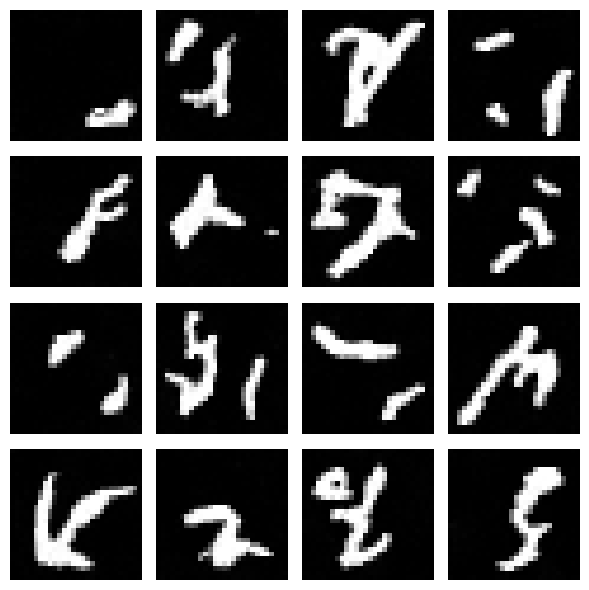

In [74]:
samples = sample_ddpm(model, n_samples=16, img_size=28, T=T, device=device)

# Визуализация
samples = samples.cpu().clamp(-1, 1) * 0.5 + 0.5  # [-1, 1] -> [0, 1]

fig, axs = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(samples[i, 0], cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()